# Name: Chloe Wohlgemuth
### COSC247
### Linear Classifiers

## Linear Classifiers Assignment Instructions
Submit a Jupyter notebook containing Python code that trains two different models, each using different learning algorithm, and compares the performance of the two learning algorithms and/or the two learned models.

At least one of your models must be produced either by logistic regression or by a support vector machine (SVM). You could compare logistic regression to SVM, or you could compare one of these to a perceptron or Adaline model. You may use the scikit-learn implementations of the models, or the "from scratch" implementations presented in our textbook and in class, or implementations that you write yourself.

The dataset that you use must include at least 500 instances. Note that some of the datasets included in scikit-learn meet this requirement, and it is fine to use one of those. You may use a dataset that you used in a previous assignment, if it includes at least 500 instances, and you may also use the same dataset as a fellow student, as long as you don't use the same dataset and perform the same comparisons as anyone else in the class, as far as you know.

For this assignment you must split your data into training and testing sets, and show how your trained models perform on each. Possible criteria for comparison include accuracy on the test set, convergence time, and robustness to changes in parameters, but this is not an exhaustive list; you should feel free to compare the algorithms/models in any meaningful way.

Be sure to include the following information in markdown cells in your notebook:

A description of the data that you are using

A description of classification task that you are training your models to perform

The two learning algorithms that you have compared

A description of the basis on which you compared them

The results of the comparison

You are encouraged to collaborate with classmates in completing this assignment, but you should acknowledge all help that you have received in your notebook file.

You can assume that your code will be run in a Python 3.8 environment in which numpy, matplotlib, pandas, and scikit-learn have been installed. Do not assume or require the installation of any other libraries.

Your should submit your notebook (.ipynb) file, your data file (probably a .csv file), and any other files that your code requires.

## Dataset Info
This is a dataset that consists of various features of NASA confirmed planets. The pertinent ones are:
* Orbital Period [days]
* Planet Mass or M*sin(i) [Jupiter mass]

#### Source
Data was produced by the NASA Exoplanet Archive: http://exoplanetarchive.ipac.caltech.edu
* Confirmed planets --> https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=planets
* Downloaded the table as a CSV file --> My file name: planets_2020.09.03_20.35.38.csv
* BUT, for ease of filename usage, I renamed to: planets090320.csv

## Purpose
The purpose in studying this dataset is to classify and compare planetary systems, specifically with regards to their quantitative properties. Plotting these properties can provide insight on the interactions and correlations between them. We do this by training an Adaline model and logistic regression model to classify between Jupiter-mass planets (class J) and Earth-mass planets (class E) based on mass and orbital period.

We will compare the performance of the different models in their classification of these planets. This can be an important task because of the different properties, compositions, behaviors, etc. of different classes of planets. This has effects on their motion, aging, reactions (chemical, atmospheric, etc), interactions with space and bodies around them, etc. Our very understanding of the universe can be based on our studies of the different celestial bodies. 

## Helpful Background Info / Assumptions
* (EXCLUDED) Super-Jupiters: planets of approx 2-13 M_J mass range
* Mid-Jupiters: planets of approx 0.5-2 M_J mass range
* (EXCLUDED) Sub-Jupiters: planets of approx 0.1-0.5 M_J mass range
* Super-/Mid-/Sub-Earths and Earthy-midplanets: 0.01-30 M_E = approx (3.14657534e-5)-0.100690411 M_J mass range

<!-- 0.0314657534 -->
#### Here, we exclude Super-Jupiters and Sub-Jupiters, to even out the proportion of data for Jupiter vs Earth class planets. We consider Jupiter class planets to have 0.5 < M < 2.1 and Earth class planets to have M < 0.100690411

Source: https://planetstar.fandom.com/wiki/Planetary_classification#:~:text=There%20are%20three%20broad%20types,in%20order%20of%20decreasing%20mass

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st

In [2]:
# these set the pandas defaults so that it will print ALL values, even for very long lists and large dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Process Dataset

In [3]:
#read in the data, skipping the first 73 rows of ancillary information
data=pd.read_csv('planets090320.csv', skiprows=76)
data = data[data['pl_bmassj']<2.1]
data = data[data['pl_orbper']<1000]

#true classfication labels of planets
data.loc[(data.pl_bmassj > 0.5),'pl_class']='J'
data.loc[(data.pl_bmassj < 0.100690411),'pl_class']='E'

#drop rows with NaN values in these columns
data = data.dropna(subset = ['pl_class','pl_bmassj','pl_orbper'])
data = data.reset_index()

#sort dataframe by the pl_class column for easy y (true-label) assignment later
data = data.sort_values(by = 'pl_class') 

#find the indices of all planet entries that are Earth class or Jupiter class
inds = [j for j in range(len(data)) if data['pl_class'][j]=='E' or data['pl_class'][j]=='J']

# dataframes for plotting
y = data.iloc[inds, 73].values # class 'dwarf' vs 'giant'
y = np.where(y == 'E', -1, 1)
X = data.iloc[inds,[7,23]].values # Orbital Period and Mass

# print(y[462:])
print("Number of Data Points: " + str(len(X)))

Number of Data Points: 915


## Plot dataset

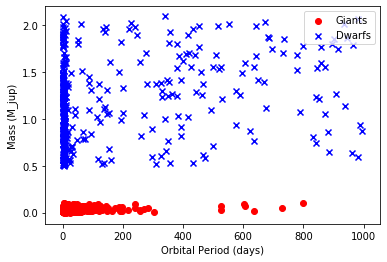

In [4]:
# plot data
plt.scatter(x=X[:463, 0], y=X[:463, 1],
            color='red', marker='o', label='Giants')
plt.scatter(x=X[463:, 0], y=X[463:, 1],
            color='blue', marker='x', label='Dwarfs')

plt.xlabel('Orbital Period (days)')
plt.ylabel('Mass (M_jup)')
plt.legend(loc='upper right')

plt.show()

## Adaline Stochastic Gradient Descent 
(to predict whether a planet belongs to the Earth-planet or Jupiter-planet categorization)

In [5]:
# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

In [6]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
#         print(self.w_)
#         print("xi:,xi,"target:),target,"output:",output,"error:"error)
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

## Logistic Regression Gradient Descent
(to predict whether a planet belongs to the Earth-planet or Jupiter-planet categorization)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c=[], #c='', ## CHANGED TO AVOID A WARNING
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

sc = StandardScaler()
sc.fit(X_train) ## Note that we standardize only on the basis of the training set
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

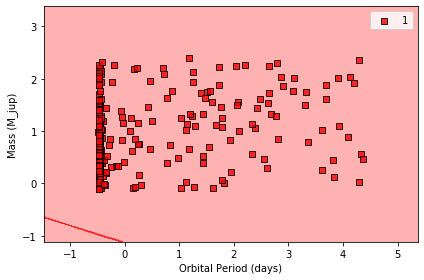

In [11]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

# lrgd = LogisticRegressionGD(eta=0.05, n_iter=100, random_state=1)
lrgd = LogisticRegressionGD(eta=0.05, n_iter=10, random_state=1)

lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)
plt.xlabel('Orbital Period (days)')
plt.ylabel('Mass (M_jup)')
plt.legend(loc='upper right')

plt.tight_layout()
#plt.savefig('images/03_05.png', dpi=300)
plt.show()

In [12]:
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)

#NOTE: C = how much we care about regularization

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=1,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [13]:
lr.predict_proba(X_test_std[:3, :])

array([[4.58876961e-06, 9.99995411e-01],
       [9.99546266e-01, 4.53734216e-04],
       [1.60736739e-06, 9.99998393e-01]])

In [14]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [15]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([1, 0, 1])

In [16]:
lr.predict(X_test_std[:3, :])

array([ 1, -1,  1])

## Results

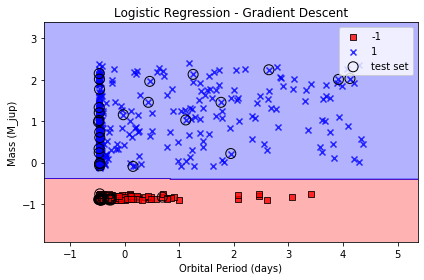

In [17]:
# lrgd = LogisticRegressionGD(eta=0.01, n_iter=100, random_state=1)
# lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
# lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.title('Logistic Regression - Gradient Descent')
plt.xlabel('Orbital Period (days)')
plt.ylabel('Mass (M_jup)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

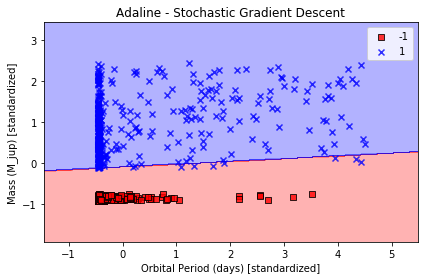

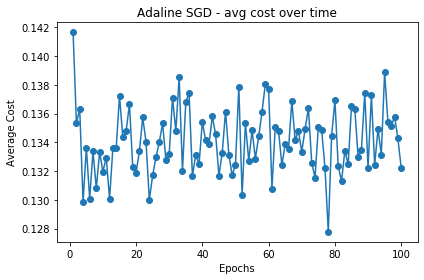

In [19]:
# ada_sgd = AdalineSGD(n_iter=2000, eta=0.01, random_state=1)
# ada_sgd = AdalineSGD(n_iter=100, eta=0.01, random_state=1)
ada_sgd = AdalineSGD(n_iter=100, eta=0.05, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Orbital Period (days) [standardized]')
plt.ylabel('Mass (M_jup) [standardized]')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.title('Adaline SGD - avg cost over time')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
plt.show()

## Comparisons - Adaline SGD vs Logistic Regression GD
* **Classification Ability** --> number of examples successfully classified

When both are set with parameters: learning_rate=eta=0.01 and n_iter=100, Logistic Regression misclassifies some points (lower mass Jupiter planets) as being Earth planets. Logistic regression does not. Even when Adaline SGD is set to n_iter=2000, it does not delineate as well as Logistic Regression (though it does improve).

* **Wallclock runtime** --> number of iterations taken

With the other (hyper) parameter kept the same, i.e. learning rate = 0.05, Logistic Regression would improve more as the number of iterations (n_iter) was increased before it reached a fully correct solution. Adaline SGD took more many more iterations and did not improve classification correctness that well at higher n_iter values. Logistic Regression correctly classifies all the examples with less than 10 iterations, whereas Adaline SGD still misclassifies a few examples with 2000+ iterations.

<!-- * Performance across **Learning Rates** -> performance (least errors) across different inputted learning rates
 -->

* Qualitatively / in context --> line of separation should be approximated by the Main Sequence on the HR diagram
The line of separation should be mostly flat line separating masses above and below a certain value. Both get the generally correct shape, though Logistic regression more accurately represents the qualitative separation relationship. This comparison is not as quantitatively significant, but is nonetheless something that can and should be noted.